# Programming Assignment 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set all the parameters to be used later

# Network structure
sizes = [785, 64, 10]

# Meta parameters
eta0 = 1e1  # initial learning rate
tau = 200  # annealing time scale
mu = 0.9  # momentum parameter
minibatch_size = 1024
capture_interval = 10

# Stopping criteria
epoch_min, epoch_max, patience = 10, None, 10

In [3]:
# Define some convenience functions
import os
from toynn.train import train


# Train a network without tricks
from toynn.network import NaiveNetwork
def naive_train(sizes):
    return train(
        NaiveNetwork(sizes), dss,
        eta0=eta0, tau=tau,
        epoch_min=epoch_min, epoch_max=epoch_max, patience=patience
    )


# Train a network with tricks
from toynn.network import TrickNetwork
def trick_train(sizes):
    return train(
        TrickNetwork(sizes), dss,
        eta0=eta0, tau=tau, mu=mu,
        minibatch_size=minibatch_size,
        capture_interval=capture_interval,
        epoch_min=epoch_min, epoch_max=epoch_max, patience=patience
    )


# Report training result
def report(result, title, compare=None):
    # Report best model parameters
    epoch = result.history['epoch']
    print('Final test accuracy:', result.history['accuracy_test'][epoch == result.final_epoch].iloc[0])
    print('Minimum validation loss:', result.loss_min)
    print('Final epoch:', result.final_epoch)
    # Make sure the `figs` directory exists
    os.makedirs('figs', exist_ok=True)
    for quantity in ['accuracy']:
        plt.figure(figsize=(8, 6))
        for label in result.data_set_labels:
            plt.plot(result.history['epoch'],
                     result.history['_'.join([quantity, label])],
                     label=label)
        # Over plot another training history for comparison
        if compare is not None:
            plt.gca().set_color_cycle(None)
            for label in compare.data_set_labels:
                plt.plot(compare.history['epoch'],
                         compare.history['_'.join([quantity, label])],
                         '--', label=label + ' (Trick)')
        plt.xlabel('Epoch')
        plt.ylabel(quantity.capitalize())
        plt.title(title.capitalize())
        plt.legend(loc='best', fancybox=True, framealpha=0.5)
        plt.ylim(0, 1)
        plt.savefig('figs/{}_{}.pdf'.format(title, quantity))
        # Zoom
        plt.ylim(0.85, 1)
        plt.savefig('figs/{}_{}_zoom.pdf'.format(title, quantity))

In [4]:
# Read the MNIST data sets
from toynn.data import read_data_sets
dss = read_data_sets()
print('Training set size:', dss.training.size)
print('Validation set size:', dss.validation.size)
print('Test set size:', dss.test.size)

Training set size: 50000
Validation set size: 10000
Test set size: 10000


## Classification

### Checking Gradients

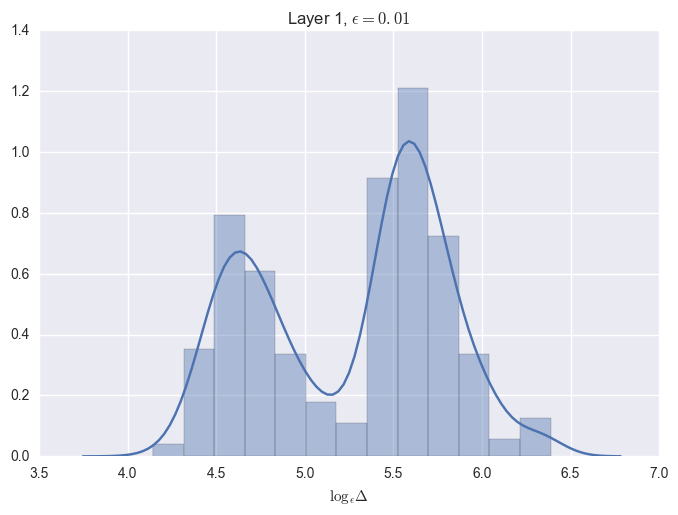

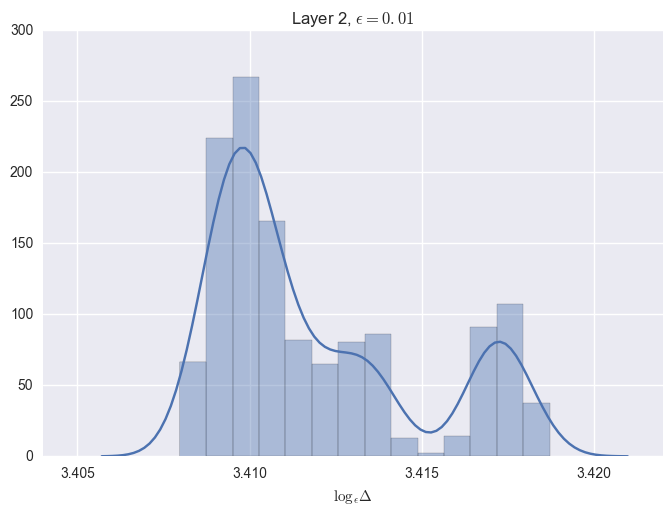

In [5]:
import pandas as pd
import seaborn as sns

net = NaiveNetwork(sizes)
net.initialize()
net.feed_data(dss.training.images[:10, :], dss.training.labels[:10, :])
net.fprop()
net.bprop()

eps=1e-2
def deltaE(l, i, j):
    w = net.layers[l].w[i, j]
    net.layers[l].w[i, j] = w + eps
    net.fprop()
    Ep = net.loss
    net.layers[l].w[i, j] = w - eps
    net.fprop()
    Em = net.loss
    net.layers[l].w[i, j] = w
    return (Ep - Em) / (2 * eps)

n_sample = 1000
for l in [1, 2]:
    layer = net.layers[l]
    result = pd.DataFrame()
    for k in range(n_sample):
        row = pd.Series()
        i = np.random.randint(layer.w.shape[0])
        j = np.random.randint(layer.w.shape[1])
        row['dE_grad'] = layer.grad[i, j]
        row['dE_diff'] = deltaE(l, i, j)
        result = result.append(row, ignore_index=True)
    delta = np.abs(result['dE_diff'] - result['dE_grad'])
    plt.figure()
    sns.distplot(np.log(delta) / np.log(eps), norm_hist=True)
    plt.xlabel('$\log_{\epsilon}\Delta$')
    plt.title('Layer {}, $\epsilon = 0.01$'.format(l))
    plt.savefig('figs/grad_diff_dist_layer_{}.pdf'.format(l))

### Gradient Descent

In [6]:
%%time
result_naive = naive_train(sizes)

CPU times: user 4min 54s, sys: 56.7 s, total: 5min 51s
Wall time: 3min 16s


Final test accuracy: 0.6977
Minimum validation loss: 0.964703430782
Final epoch: 152.0


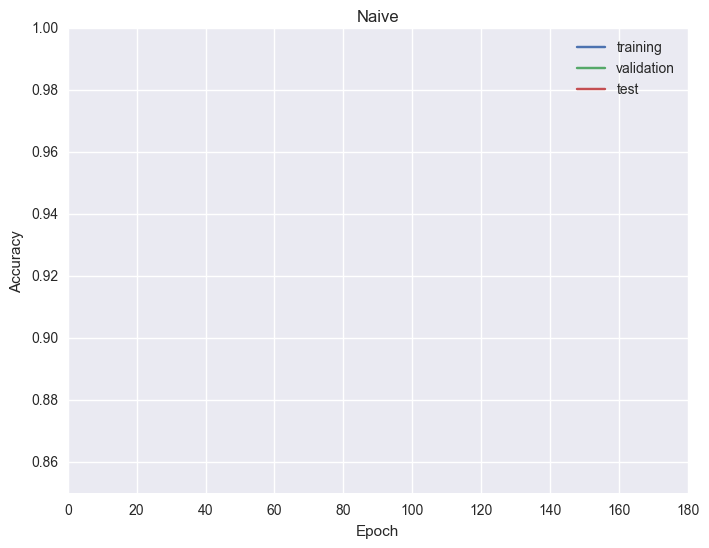

In [7]:
report(result_naive, 'naive')

## Tricks of the Trade

In [8]:
%%time
result_trick = trick_train(sizes)

CPU times: user 20min 59s, sys: 2min 27s, total: 23min 27s
Wall time: 12min 30s


Final test accuracy: 0.946
Minimum validation loss: 0.276583127851
Final epoch: 252.0


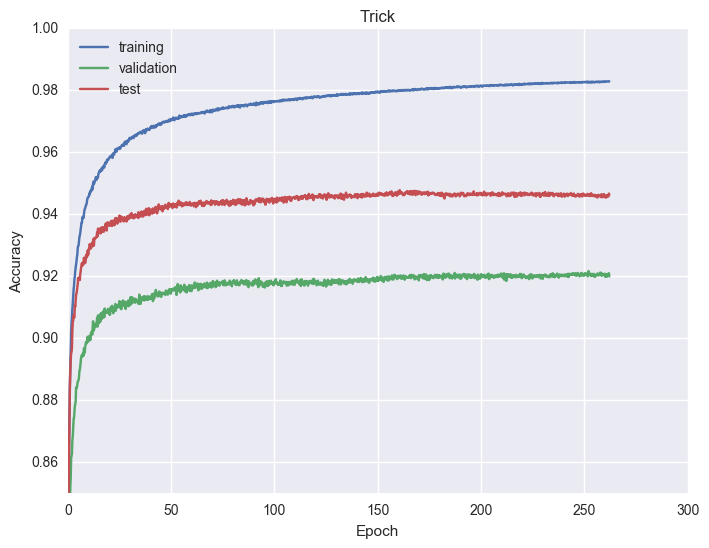

In [9]:
report(result_trick, 'trick')

## Network Topology

### Number of Hidden Units

In [10]:
%%time
sizes_narrow = sizes.copy()
sizes_narrow[1] //= 2
result_narrow = trick_train(sizes_narrow)

CPU times: user 7min 35s, sys: 1min 7s, total: 8min 43s
Wall time: 4min 47s


Final test accuracy: 0.9259
Minimum validation loss: 0.386465893008
Final epoch: 126.625


/Users/xly/miniconda3/envs/py3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


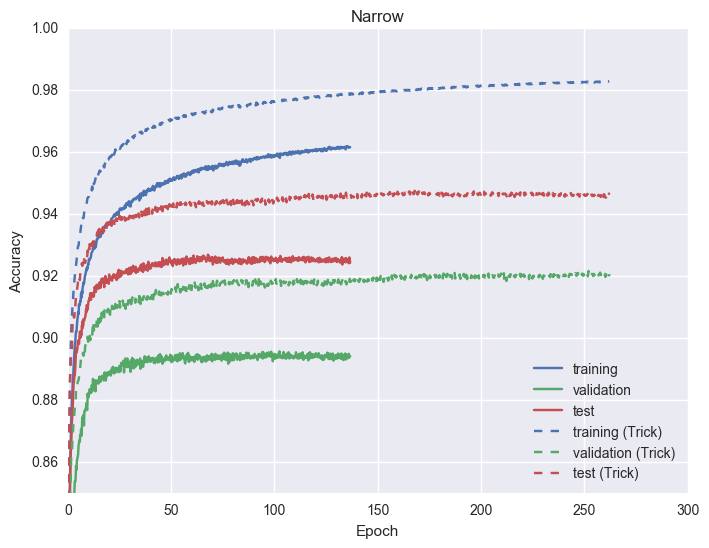

In [11]:
report(result_narrow, 'narrow', compare=result_trick)

In [12]:
%%time
sizes_wide = sizes.copy()
sizes_wide[1] *= 2
result_wide = trick_train(sizes_wide)

CPU times: user 46min 53s, sys: 4min 53s, total: 51min 46s
Wall time: 27min 38s


Final test accuracy: 0.9569
Minimum validation loss: 0.218489867644
Final epoch: 337.416666667


/Users/xly/miniconda3/envs/py3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


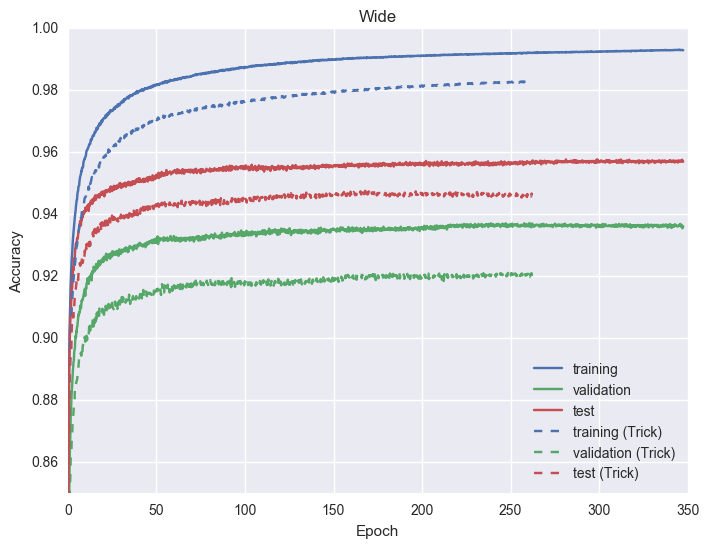

In [13]:
report(result_wide, 'wide', compare=result_trick)

### Number of Hidden Layers

In [14]:
%%time
d_in, d_old, d_out = sizes
# Solve the new dimension
d_sum = d_in + d_out
d_new = int(np.round((np.sqrt(d_sum ** 2 + 4 * d_sum * d_old) - d_sum) / 2))
print('New hidden layer dimension is', d_new)
sizes_deep = [d_in, d_new, d_new, d_out]
result_deep = trick_train(sizes_deep)

New hidden layer dimension is 60
CPU times: user 7min 36s, sys: 58.4 s, total: 8min 34s
Wall time: 4min 34s


Final test accuracy: 0.9556
Minimum validation loss: 0.238092379904
Final epoch: 64.0


/Users/xly/miniconda3/envs/py3/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


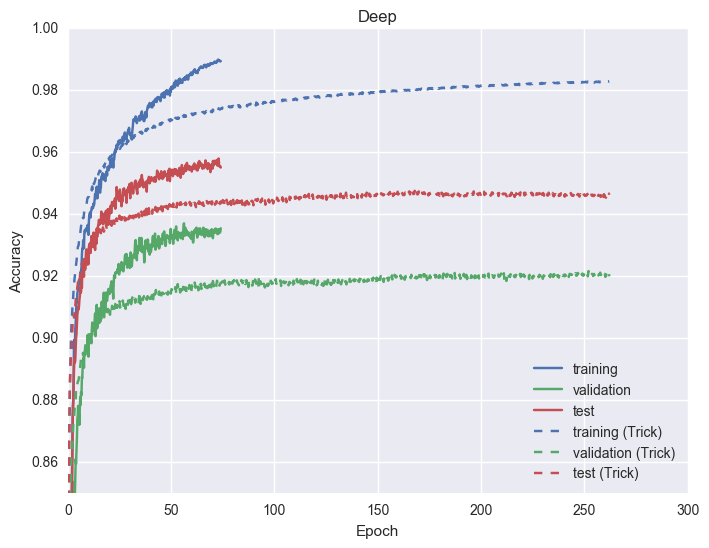

In [15]:
report(result_deep, 'deep', compare=result_trick)